# Inspect RFI in VLA Data
This notebook generates plots (waterfalls and spectra) that are useful in identifying RFI in VLA data. The plors show both the data before and after flagging.

In [20]:
import os
import sys
import numpy as np
from pyuvdata import UVData

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

cmap = mpl.cm.viridis 
cmap.set_bad(color='red')

from ipywidgets import interact

from astropy.time import Time
import astropy.units as u

# read yaml file
with open("obs.yaml", "r") as file:
    obs = yaml.safe_load(file)
sys.path.append(obs["root"])

from vlapy import vladata
from vlapy import inspect

## Load Data

In [21]:
# number of integrations per scan
avg_ntimes = [28, 238, 65, 56, 248, 69, 72, 249, 64]
scan_boundaries = [28, 238, 121, 248, 69, 72, 249, 64]

# Bins in metres for baseline averaging. 
bls_bins = [1, 1000, 3000, 5000, 10000, 20000, 30000, 40000]

# get masked and unmasked data
data_masked = inspect.get_data_products(obs["ms hanning"], avg_ntimes, bls_bins, masked=True, data_column="CORRECTED_DATA")
data_unmasked = inspect.get_data_products(obs["ms hanning"], avg_ntimes, bls_bins, masked=False, data_column="CORRECTED_DATA")

Coordinate reference frame not detected, defaulting to ICRS
UVW orientation appears to be flipped, attempting to fix by changing conjugation of baselines.
Coordinate reference frame not detected, defaulting to ICRS
UVW orientation appears to be flipped, attempting to fix by changing conjugation of baselines.


## Data
The visibility amplitudes are first averaged across baselines and polarisation products. A modified Z-score is then computed across time as $Z_i = \frac{x_i - \mathrm{med}\{x_i\}_i}{\sigma_\mathrm{MAD}}$, 

where $\sigma_\mathrm{MAD} = \mathrm{med}\{\left|x_i - \mathrm{med}\{x_i\}_i\right|\}$ is the Median Absolute Deviation (MAD), and $x_i$ is the data (visibility amplitude) of the $i^\mathrm{th}$ integration.

The resulting Z-score is a spectrogram with dimensions of time and frequency. It can further be averaged across one of these dimensions to obtain a time series or a spectrum, which are useful for identifying broadband and persistent narrowband RFI respectively.

Furthermore, Z-scores are generated of data that has only been averaged across baselines formed by a single antenna or across belines in a particular range of baseline lengths (specified above). This allow to identify RFI that is only seen by some antennas or baseline lengths.

In [22]:
freq_array = data_masked["freq array"]
time_array = data_masked["time array"]
ant_names = data_masked["ant names"]
dt = data_masked["dt"]

rfi_wf_masked = data_masked["rfi wf"]
rfi_wf_norm_masked = np.abs(data_masked["rfi wf norm"])
rfi_spec_masked = data_masked["rfi spec"]
per_ant_wf_masked = data_masked["per ant wf"]
per_ant_spec_masked = data_masked["per ant spec"]
bls_bin_wf_masked = data_masked["bls bin wf"]
bls_bin_spec_masked = data_masked["bls bin spec"]

rfi_wf_unmasked = data_unmasked["rfi wf"]
rfi_wf_norm_unmasked = np.abs(data_unmasked["rfi wf norm"])
rfi_spec_unmasked = data_unmasked["rfi spec"]
per_ant_wf_unmasked = data_unmasked["per ant wf"]
per_ant_spec_unmasked = data_unmasked["per ant spec"]
bls_bin_wf_unmasked = data_unmasked["bls bin wf"]
bls_bin_spec_unmasked = data_unmasked["bls bin spec"]

t = Time(np.unique(time_array), format="jd", scale="utc")

(1089,) [0.00000000e+00 2.31480226e-05 2.31484883e-05 4.62960452e-05
 4.62965108e-05]


## Plot Time Series
Visibility amplitude Z-score averaged across baselines and frequency. Uncomment "matplotlib %inline" to zoom into the plot and find the exact time ranges that need to be flagged.

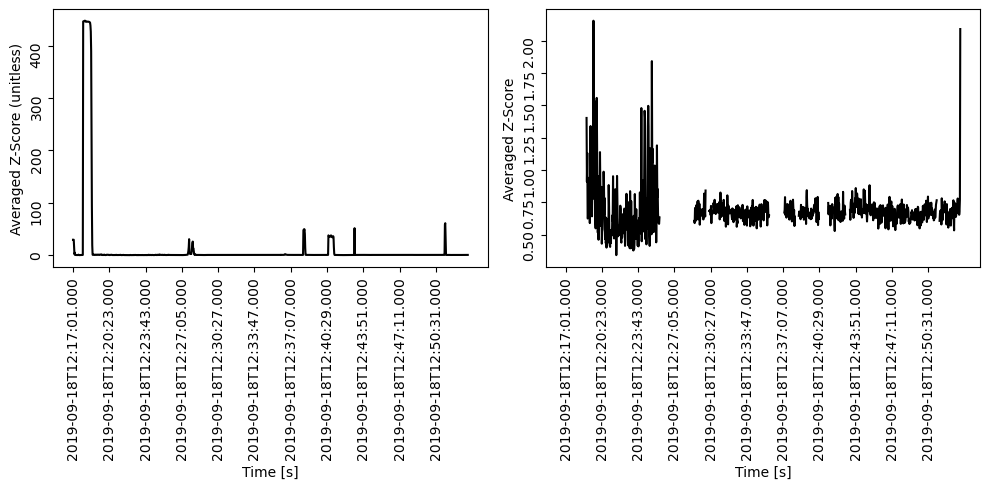

In [43]:
# %matplotlib inline
imp.reload(inspect)
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax[0] = inspect.plot_time_series(t.isot, np.ma.median(rfi_wf_norm_unmasked, axis=1), ax[0], plot_masked=False)
ax[1] = inspect.plot_time_series(t.isot, np.ma.median(rfi_wf_norm_masked, axis=1), ax[1], plot_masked=True)
ax[0].set_ylabel("Averaged Z-Score (unitless)")
ax[0].set_xticks(t.isot[::100])
ax[1].set_xticks(t.isot[::100])
plt.tight_layout()

## Plot Z-Score Spectrograms

### averaged across all baselines

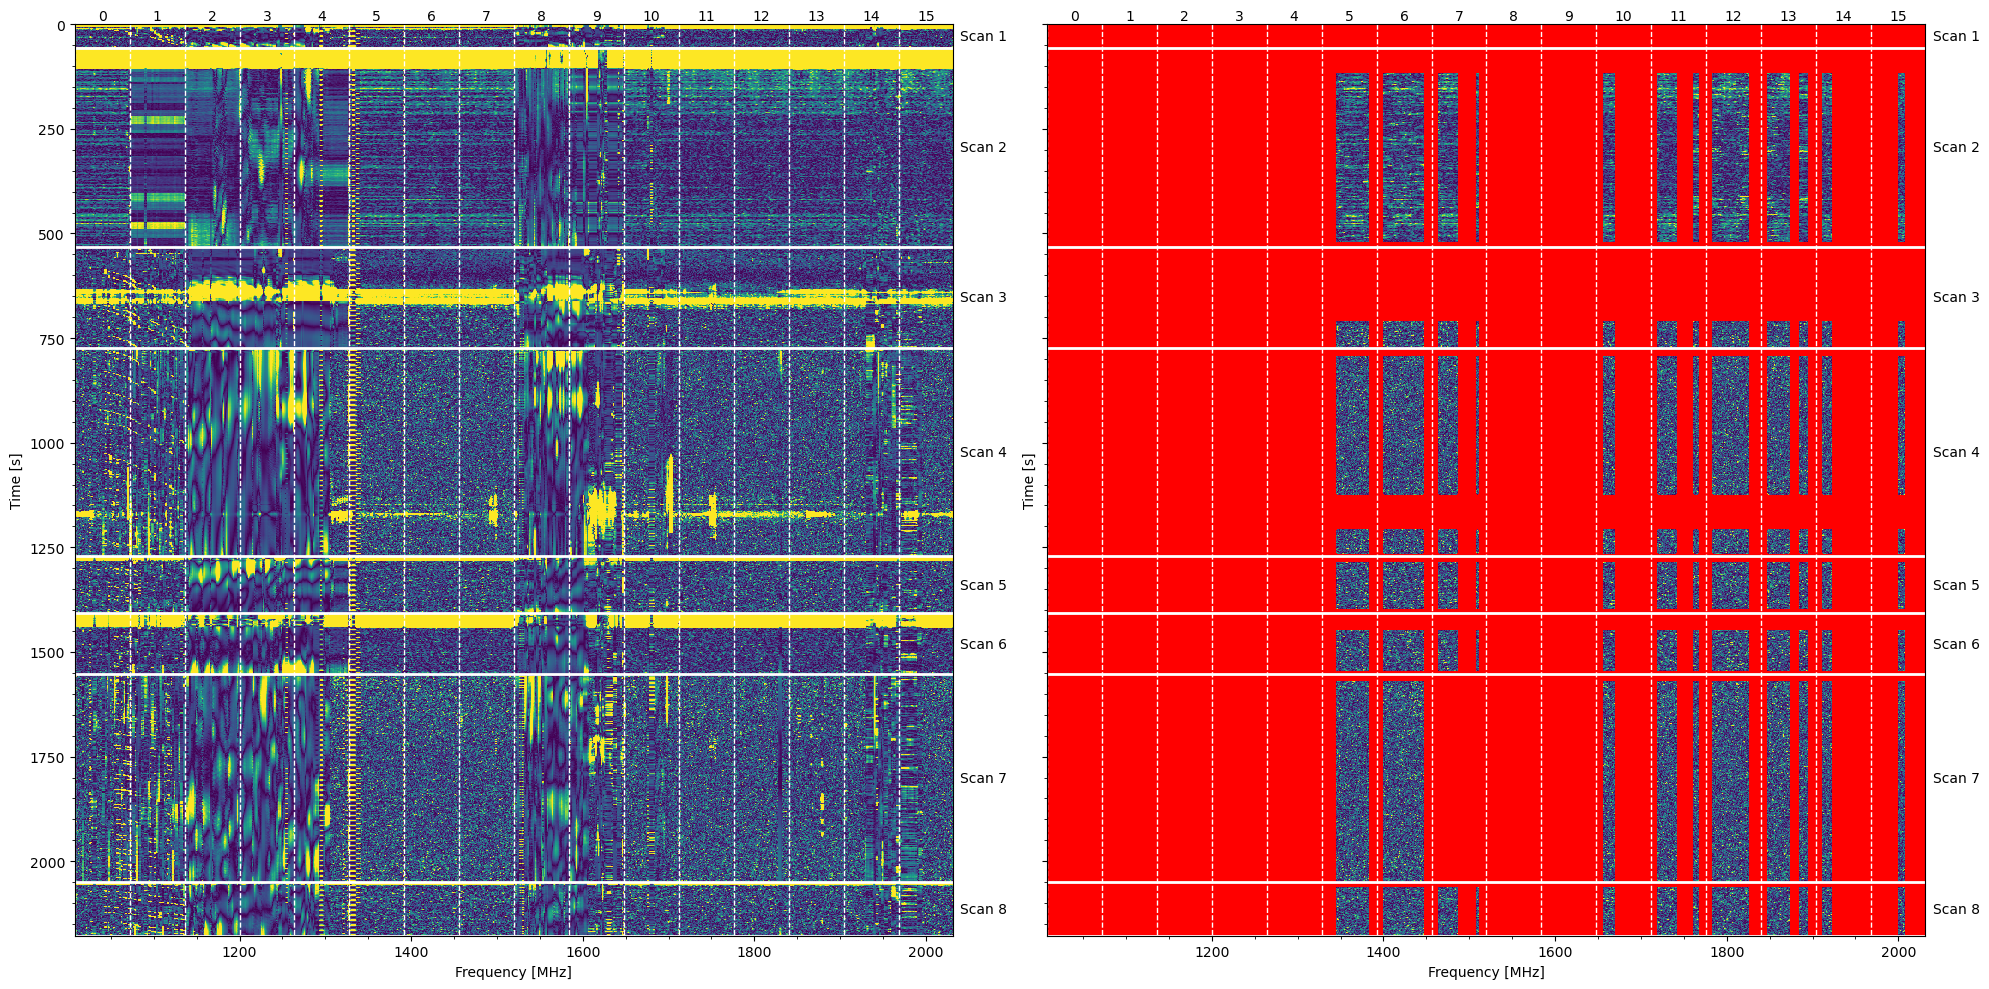

In [26]:
imp.reload(inspect)

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
ax[0], im = inspect.plot_wf(freq_array, rfi_wf_norm_unmasked, 2, scan_boundaries, vmin=0, vmax=3, cmap=cmap, ax=ax[0], plot_masked=False)
ax[1], im = inspect.plot_wf(freq_array, rfi_wf_norm_masked, 2, scan_boundaries, vmin=0, vmax=3, cmap=cmap, ax=ax[1], plot_masked=True)


In [27]:
imp.reload(inspect)

def plot_wf_spw(i):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
    ax[0] = inspect.plot_wf_spw(freq_array, rfi_wf_norm_unmasked, i, 2, scan_boundaries, ax=ax[0], cmap=cmap)
    ax[1] = inspect.plot_wf_spw(freq_array, rfi_wf_norm_masked, i, 2, scan_boundaries, ax=ax[1], cmap=cmap, plot_masked=True)
    
interact(plot_wf_spw, i=(0, 15))

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_wf_spw(i)>

###  averaged across baselines formed by an antenna
Iterate over antennas.

In [28]:
imp.reload(inspect)

def plot_ant_wf(i):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
    ax[0], im = inspect.plot_wf(freq_array, per_ant_wf_unmasked[i], ax=ax[0], cmap=cmap, vmin=0, vmax=3);
    ax[0].set_title(f"Antenna {ant_names[i]}", pad=25)
    ax[1], im = inspect.plot_wf(freq_array, per_ant_wf_masked[i], ax=ax[1], cmap=cmap, vmin=0, vmax=3, plot_masked=True);
    ax[1].set_title(f"Antenna {ant_names[i]}", pad=25)
    
interact(plot_ant_wf, i=(0, 26))

interactive(children=(IntSlider(value=13, description='i', max=26), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_ant_wf(i)>

In [29]:
imp.reload(inspect)

def plot_ant_wf_spw(i, j):
    print(f"Antenna {ant_names[i]}")
    fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
    ax[0] = inspect.plot_wf_spw(freq_array, per_ant_wf_unmasked[i], j, 2, scan_boundaries, ax=ax[0], cmap=cmap)
    ax[1] = inspect.plot_wf_spw(freq_array, per_ant_wf_masked[i], j, 2, scan_boundaries, ax=ax[1], cmap=cmap, plot_masked=True)
    
interact(plot_ant_wf_spw, i=(0, 26), j=(0, 15))

interactive(children=(IntSlider(value=13, description='i', max=26), IntSlider(value=7, description='j', max=15…

<function __main__.plot_ant_wf_spw(i, j)>

### amplitudes averaged across baselines within a particular range of baseline lengths
Iterate over baseline length bins.

In [30]:
def plot_bls_bin_wf(i):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
    ax[0], im = inspect.plot_wf(freq_array, bls_bin_wf_unmasked[i], ax=ax[0], cmap=cmap, vmin=0, vmax=3);
    ax[1], im = inspect.plot_wf(freq_array, bls_bin_wf_masked[i], ax=ax[1], cmap=cmap, vmin=0, vmax=3, plot_masked=True);

    ax[0].set_title(fr"Baseline Lengths: ${bls_bins[i] // 1000}-{bls_bins[i+1] // 1000}\,$km", pad=25)
    ax[1].set_title(fr"Baseline Lengths: ${bls_bins[i] // 1000}-{bls_bins[i+1] // 1000}\,$km", pad=25)
    
interact(plot_bls_bin_wf, i=(0, 6))

interactive(children=(IntSlider(value=3, description='i', max=6), Output()), _dom_classes=('widget-interact',)…

<function __main__.plot_bls_bin_wf(i)>

In [31]:
imp.reload(inspect)
def plot_bls_bins_wf_spw(i, j):
    print(fr"Baseline Lengths: {bls_bins[i] // 1000}-{bls_bins[i+1] // 1000} km")
    fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
    ax[0] = inspect.plot_wf_spw(freq_array, bls_bin_wf_unmasked[i], j, 2, scan_boundaries, ax=ax[0], cmap=cmap)
    ax[1] = inspect.plot_wf_spw(freq_array, bls_bin_wf_masked[i], j, 2, scan_boundaries, ax=ax[1], cmap=cmap, plot_masked=True)
    
interact(plot_bls_bins_wf_spw, i=(0, 6), j=(0, 15))

interactive(children=(IntSlider(value=3, description='i', max=6), IntSlider(value=7, description='j', max=15),…

<function __main__.plot_bls_bins_wf_spw(i, j)>

## Plot Spectra
The red shaded regions are known to be affected by strong RFI.

### averaged across times and baselines

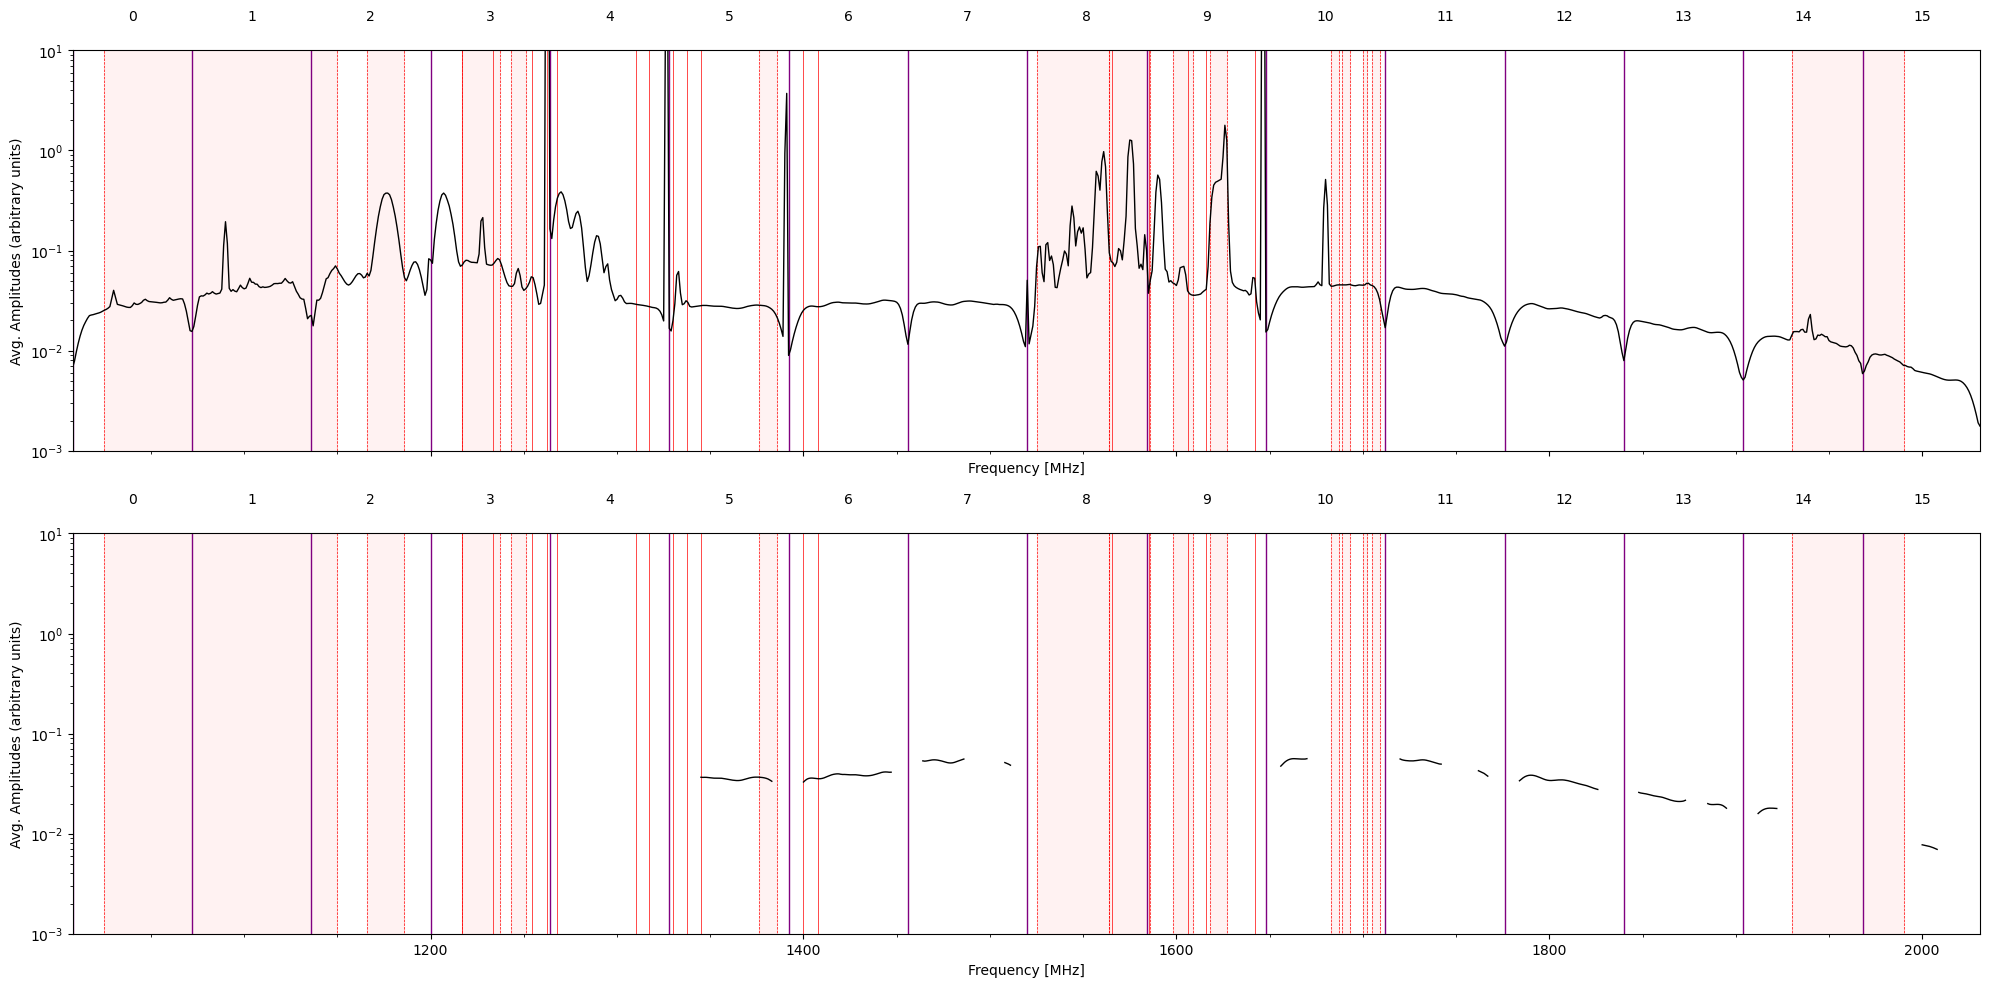

In [32]:
from vlapy.rfi_freq import rfi_freq_continuous_or_strong
imp.reload(inspect)
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True, sharey=True)

ax[0] = inspect.plot_spec(freq_array, rfi_spec_unmasked, rfi_ranges=rfi_freq_continuous_or_strong, ax=ax[0]);
ax[1] = inspect.plot_spec(freq_array, rfi_spec_masked, rfi_ranges=rfi_freq_continuous_or_strong, ax=ax[1], plot_masked=True);

In [33]:
imp.reload(inspect)
def plot_spec_spw(i):
    fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax[0] = inspect.plot_spec_spw(freq_array, rfi_spec_unmasked, i, ax=ax[0], fig=fig)
    ax[1] = inspect.plot_spec_spw(freq_array, rfi_spec_masked, i, ax=ax[1], fig=fig, plot_masked=True)
    
interact(plot_spec_spw, i=(0, 15))

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_spec_spw(i)>

### averaged across times and baselines formed by an antenna
Iterate over antennas.

In [34]:
def plot_ant_spec(i):
    fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax[0] = inspect.plot_spec(freq_array, per_ant_spec_unmasked[i], ax=ax[0]);
    ax[0].set_title(f"Antenna {ant_names[i]}", pad=25)
    ax[1] = inspect.plot_spec(freq_array, per_ant_spec_masked[i], ax=ax[1], plot_masked=True);
    
interact(plot_ant_spec, i=(0, 26))

interactive(children=(IntSlider(value=13, description='i', max=26), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_ant_spec(i)>

In [35]:
imp.reload(inspect)
def plot_spec_spw(i, j):
    print(f"Antenna {ant_names[i]}")
    fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax[0] = inspect.plot_spec_spw(freq_array, per_ant_spec_unmasked[i], j, ax[0], fig)
    ax[1] = inspect.plot_spec_spw(freq_array, per_ant_spec_masked[i], j, ax[1], fig, plot_masked=True)

interact(plot_spec_spw, i=(0, 26), j=(0, 15))

interactive(children=(IntSlider(value=13, description='i', max=26), IntSlider(value=7, description='j', max=15…

<function __main__.plot_spec_spw(i, j)>

### averaged across times and baselines within a particular range of baseline lengths
Iterate over baseline length bins.

In [36]:
def plot_bls_bin_spec(i):
    fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax[0] = inspect.plot_spec(freq_array, bls_bin_spec_unmasked[i], ax=ax[0]);
    ax[0].set_title(fr"Baseline Lengths: ${bls_bins[i] // 1000}-{bls_bins[i+1] // 1000}\,$km", pad=25)
    ax[1] = inspect.plot_spec(freq_array, bls_bin_spec_masked[i], ax=ax[1], plot_masked=True);

interact(plot_bls_bin_spec, i=(0, 3))

interactive(children=(IntSlider(value=1, description='i', max=3), Output()), _dom_classes=('widget-interact',)…

<function __main__.plot_bls_bin_spec(i)>

In [37]:
imp.reload(inspect)
def plot_spec_spw(i, j):
    print(fr"Baseline Lengths: {bls_bins[i] // 1000}-{bls_bins[i+1] // 1000} km")
    fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax[0] = inspect.plot_spec_spw(freq_array, bls_bin_spec_unmasked[i], j, ax[0], fig)
    ax[1] = inspect.plot_spec_spw(freq_array, bls_bin_spec_masked[i], j, ax[1], fig, plot_masked=True)

interact(plot_spec_spw, i=(0, 3), j=(0, 15))

interactive(children=(IntSlider(value=1, description='i', max=3), IntSlider(value=7, description='j', max=15),…

<function __main__.plot_spec_spw(i, j)>

### Plot spectral window summary

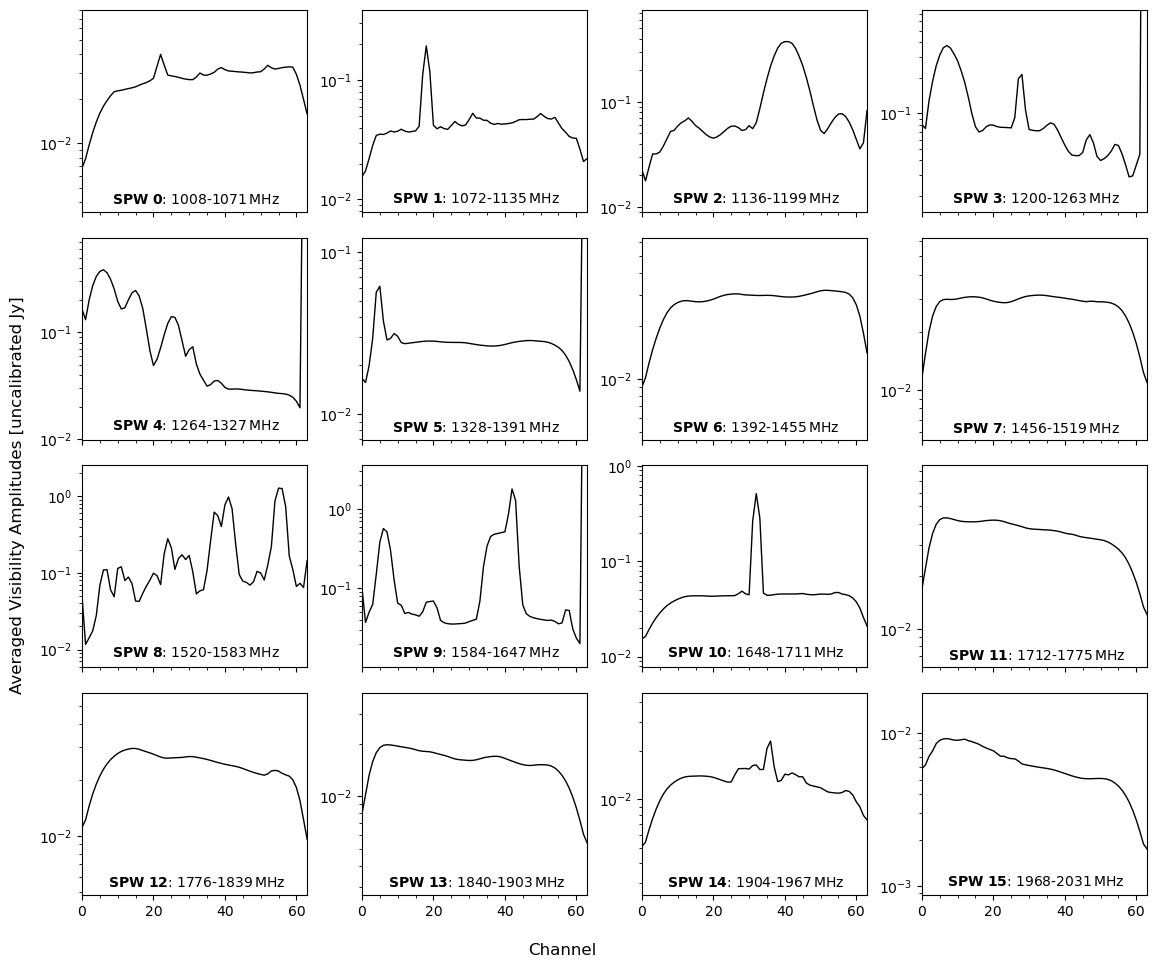

In [38]:
imp.reload(inspect)

inspect.plot_spec_spw_summary(freq_array, rfi_spec_unmasked);